In [1]:
import sys
import numpy as np
import torch
sys.path.append("../")  
import src.RBM as rbm
import src.RBM_P as rbm_p

In [ ]:
visible_dim = 443136 
hidden_dim = 1000
sigma = 10
RBM =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)


In [ ]:
print(RBM)

GaussianBinaryRBM()
GaussianBinaryRBM_P()


In [4]:
batch_size = 10
Batch_data = torch.randn(batch_size, visible_dim)
Batch_data = torch.tanh(Batch_data)
print(Batch_data)

tensor([[ 0.8944, -0.1439, -0.8365,  ..., -0.6255,  0.7743, -0.9341],
        [ 0.9553, -0.8610, -0.1465,  ...,  0.6019, -0.6586,  0.2439],
        [ 0.3627,  0.8598, -0.4994,  ..., -0.9691,  0.3584,  0.9016],
        ...,
        [-0.2609,  0.4114,  0.1532,  ..., -0.6974, -0.0204,  0.5684],
        [-0.6724,  0.3085,  0.7836,  ...,  0.9107,  0.5299, -0.5646],
        [-0.9605,  0.6637, -0.9886,  ...,  0.4978, -0.9068, -0.7660]])


In [5]:
import matplotlib.pyplot as plt

def plot_erreur(epoch, error):
    """" Tracer la courbe d'évolution de l'erreur """
    
    plt.plot(range(epoch), error, label="Erreur de reconstruction")
    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de l'erreur de reconstruction")
    plt.legend()
    plt.show() 

In [ ]:
epoch = 10
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)

for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    RBM.contrastive_divergence(Batch_data)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM.forward(Batch_data)

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    # Imprimer Batch_error pour voir l'écart entre les données et les prédictions
    #print(f"Batch_error: {Batch_error}")
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique



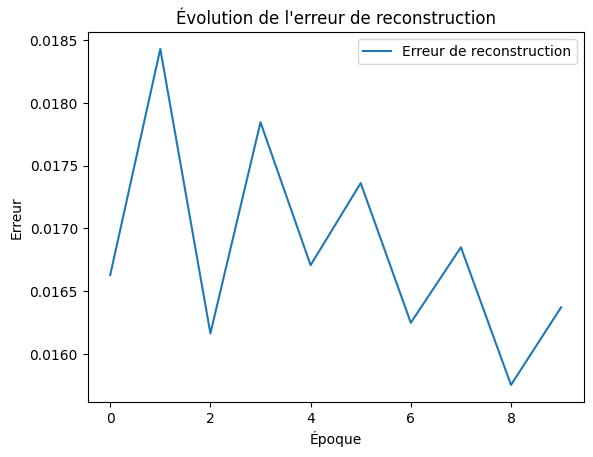

In [7]:
plot_erreur(epoch, error_score)

Alors on remarque là une parallélisation contre productive.

In [26]:
# Sauvegarder le modèle 

torch.save(RBM.state_dict(), '../models_saved/RBM_contrast_div.pth')

In [27]:
import multiprocessing